In [1]:
import pachinko
nbatches = 10000
nperevent = 10
depos = pachinko.random_depos(nbatches, nperevent)

def dump_deposet(depos):
    print(depos.shape)
    print("\tx\ty\tq\tsigma")
    for one in depos[:,:]:
        print("".join([f'{t:9.5}' for t in one.unbind()]))
dump_deposet(depos[0])


torch.Size([10, 4])
	x	y	q	sigma
   863.63   15.489      1.0      0.0
   336.42   29.716      1.0      0.0
   871.92   8.6365      1.0      0.0
   194.97   48.846      1.0      0.0
   512.73  -9.7032      1.0      0.0
   618.74   38.358      1.0      0.0
   51.316   36.878      1.0      0.0
   331.87   16.249      1.0      0.0
   39.311   44.592      1.0      0.0
    401.3  -28.002      1.0      0.0


In [2]:
import torch
true_dt = 0.01
true_lt = 3000.0
drifter = pachinko.Drifter(true_dt, true_lt)
drifter2 = pachinko.Drifter(0.02, 2000.0)
print('Drifter       DT:', drifter.param_dt.item(), drifter.DT.item())
print('Drifter lifetime:', drifter.param_lt.item(), drifter.lifetime.item())
with torch.no_grad():
    drifted = drifter(depos[0])
    drifted2 = drifter2(depos[0])
dump_deposet(drifted)


Drifter       DT: -4.595119953155518 0.009999998845160007
Drifter lifetime: -0.8472977876663208 3000.0
torch.Size([10, 4])
	x	y	q	sigma
      0.0   15.489  0.74985    4.156
      0.0   29.716  0.89392   2.5939
      0.0   8.6365  0.74778   4.1759
      0.0   48.846  0.93708   1.9747
      0.0  -9.7032   0.8429   3.2023
      0.0   38.358  0.81363   3.5178
      0.0   36.878  0.98304   1.0131
      0.0   16.249  0.89528   2.5763
      0.0   44.592  0.98698  0.88669
      0.0  -28.002  0.87479    2.833


In [3]:
nwires = 21
pitch = 5.0
span = nwires * pitch
half = 0.5*span
bins = torch.linspace(-half, half, nwires+1)
collector = pachinko.Collector(bins)
with torch.no_grad():
    adcs = collector(drifted)
    adcs2 = collector(drifted2)
print(adcs)
print(adcs2)

tensor([0.0000e+00, 0.0000e+00, 9.3855e-07, 1.0839e-02, 5.1301e-01, 3.4830e-01,
        2.8867e-03, 9.1176e-02, 6.1210e-01, 1.3882e-01, 1.4673e-02, 2.5022e-01,
        5.4582e-01, 1.1762e+00, 3.9994e-01, 1.0811e-01, 7.4221e-01, 1.1406e+00,
        6.6768e-01, 1.1827e+00, 7.7583e-01])
tensor([0.0000e+00, 1.2192e-07, 3.2821e-04, 4.5659e-02, 4.2059e-01, 3.3029e-01,
        2.7018e-02, 1.4233e-01, 4.3568e-01, 1.8316e-01, 5.3364e-02, 2.2565e-01,
        4.7489e-01, 9.1549e-01, 4.4646e-01, 1.9977e-01, 5.9507e-01, 1.0913e+00,
        6.2369e-01, 1.2796e+00, 6.5702e-01])


We make a "reality" and "model" modules which are sequential compositions of a drifter and collector, with different parameters.  

In [15]:


reality = pachinko.make_model(0.01, 3000.0, pitch, nwires)
model = pachinko.make_model(0.02, 2000.0, pitch, nwires)
drifter, collector = reality.children()
print(drifter.DT, drifter.lifetime)
print(collector.binning)
print(collector.binning.shape, adcs.shape)
with torch.no_grad():
    r_adcs = reality(depos[0])
    m_adcs = model(depos[0])


tensor(0.0100, grad_fn=<AddBackward0>) tensor(3000., grad_fn=<AddBackward0>)
tensor([-52.5000, -47.5000, -42.5000, -37.5000, -32.5000, -27.5000, -22.5000,
        -17.5000, -12.5000,  -7.5000,  -2.5000,   2.5000,   7.5000,  12.5000,
         17.5000,  22.5000,  27.5000,  32.5000,  37.5000,  42.5000,  47.5000,
         52.5000])
torch.Size([22]) torch.Size([21])


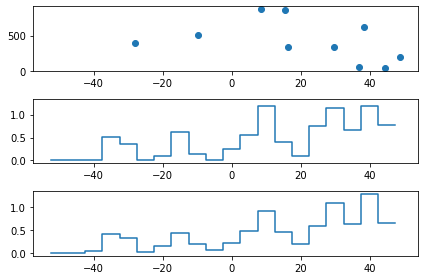

In [16]:
import matplotlib.pyplot as plt
ax1 = plt.subplot(311)
ax1.scatter(depos[0, :, 1], depos[0, :, 0])
ax2 = plt.subplot(312, sharex=ax1)
ax2.step(collector.binning[:-1], r_adcs)
ax3 = plt.subplot(313, sharex=ax2, sharey=ax2)
ax3.step(collector.binning[:-1], m_adcs)
plt.tight_layout()

Above shows (top) the original depo locations in x vs y prior to drifting to x=0, and (middle) the "ADC" per channel for "reality" drift model and (bottom) same for the initial "model" to be optimized against "reality".  The latter should have more absorption (shorter lifetime) and more diffusion so should have lower wider peaks compared to "reality".

Next we do one training of "model" against "reality" (note, these modules are remade inside the function).

In [17]:
nper = 10
batch_size = 100
nevent = batch_size * 1000
pachinko.test_train(epochs=1, batch_size=batch_size, learning_rate=0.01, num_workers=4, nevent=nevent, nper=nper)

parameter: ('0.param_dt', Parameter containing:
tensor(-3.8918, requires_grad=True))
parameter: ('0.param_lt', Parameter containing:
tensor(-1.3863, requires_grad=True))
Epoch 1
-------------------------------
loss: 0.010907  [    0/100000] DT:0.019995735958218575 lt:2000.209716796875
loss: 0.010018  [ 1000/100000] DT:0.01995580643415451 lt:2002.2777099609375
loss: 0.010714  [ 2000/100000] DT:0.01991584151983261 lt:2004.347412109375
loss: 0.010876  [ 3000/100000] DT:0.019876323640346527 lt:2006.3948974609375
loss: 0.010377  [ 4000/100000] DT:0.01983724907040596 lt:2008.438232421875
loss: 0.010111  [ 5000/100000] DT:0.019798045977950096 lt:2010.49755859375
loss: 0.010415  [ 6000/100000] DT:0.0197583120316267 lt:2012.563232421875
loss: 0.009985  [ 7000/100000] DT:0.019718792289495468 lt:2014.647705078125
loss: 0.010047  [ 8000/100000] DT:0.019679918885231018 lt:2016.6842041015625
loss: 0.010457  [ 9000/100000] DT:0.01964084431529045 lt:2018.7249755859375
loss: 0.010130  [10000/100000] DT

If all goes well, given enough epochs, this should converge to the "reality" values of `DT=0.01` and `lifetime=3000`.  In tests, some 30 epochs are needed resulting in a loss of 0.000001 and DT:0.01033917348831892 and lt:2986.109619140625.